In [210]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import get_data
import model, optimize, net, ode
import torch
import gpytorch

import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [364]:
extent =[-84,-77,29,34]

T,XY,Z, XY_UV = get_data.goes("2024-02-24", minutes= 60, hours = 6, extent =extent)

 👮🏻‍♂️ File already exists. Do not overwrite: /home/yf297/data/noaa-goes16/ABI-L2-MCMIPC/2024/055/00/OR_ABI-L2-MCMIPC-M6_G16_s20240550001172_e20240550003545_c20240550004064.nc
📦 Finished downloading [1] files to [/home/yf297/data/noaa-goes16/ABI-L2-MCMIPC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [365]:
data = model.data(T,XY,Z[1],XY_UV)
data.extent = extent

In [366]:
data.XY.shape

torch.Size([68366, 2])

In [367]:
sub = 10000
indices = torch.randperm(data.m)[:sub]
data.plot_observations(indices)

In [368]:
sub = 1000
data.indices = torch.randperm(data.m)[:sub]

kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu = 5/2, ard_num_dims = 3))
likelihood = gpytorch.likelihoods.GaussianLikelihood()


In [369]:
gp = model.GP(kernel, likelihood)

In [370]:
optimize.gp(gp, data, num_epochs=200)

Epoch: 25 - Likelihood: 2.266
Epoch: 50 - Likelihood: 1.984
Epoch: 75 - Likelihood: 1.852
Epoch: 100 - Likelihood: 1.735
Epoch: 125 - Likelihood: 1.628
Epoch: 150 - Likelihood: 1.547
Epoch: 175 - Likelihood: 1.490
Epoch: 200 - Likelihood: 1.443


In [371]:
gc.collect()
torch.cuda.empty_cache()

In [372]:
flow = net.Flow(L = 5, S = T)

In [373]:
optimize.flow_vecchia(gp, flow, data, num_epochs=100)

Epoch: 10 - Likelihood: 1.040
Epoch: 20 - Likelihood: 0.977
Epoch: 30 - Likelihood: 0.966
Epoch: 40 - Likelihood: 0.960
Epoch: 50 - Likelihood: 0.956
Epoch: 60 - Likelihood: 0.952
Epoch: 70 - Likelihood: 0.948
Epoch: 80 - Likelihood: 0.945
Epoch: 90 - Likelihood: 0.943
Epoch: 100 - Likelihood: 0.940


In [374]:
vel_hat = ode.Vel_hat(flow, data)
data.vel = vel_hat

In [375]:
gc.collect()

21

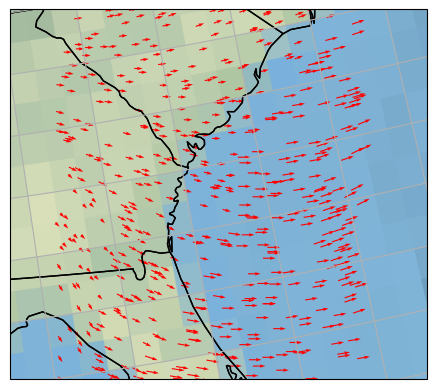

In [380]:
sub = 500
indices = torch.randperm(data.m)[:sub]
data.plot_vel(indices, frame = 2)